# Gaussian Process Classification with GPy

In this notebook, we want to show how to apply a simple GPy classifier and craft adversarial examples on it.
Let us start by importing all things we might use to train a model and visualize it.

In [1]:
from art.attacks import HighConfidenceLowUncertainty, ProjectedGradientDescent
from art.estimators.classification import GPyGaussianProcessClassifier

import GPy
from sklearn.datasets import  make_moons
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Training a classifier
We will first train a classifier. The classifier is limited to binary classification problems and scales quadratically with the data, so we use a very simple and basic data set here.

Once the code runs, we see a summary of the model and a visualization of the classifier. The shade of the samples is directly related to the confidence of the GP in its classification.

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0003   2.013831e+01   1.868027e+00 
    00s68  0021   1.648188e+01   1.741965e-10 
Runtime:     00s68
Optimization status: Converged



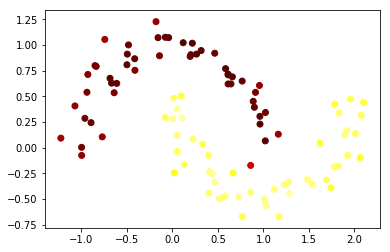

In [2]:
np.random.seed(6)
X, y = make_moons(n_samples=100, noise=0.1)
#getting a kernel for GPy. Gradients work for any kernel.
gpkern = GPy.kern.RBF(np.shape(X)[1])
#get the model
m = GPy.models.GPClassification(X, y.reshape(-1,1), kernel=gpkern)
m.rbf.lengthscale.fix(0.4)
#determining the infernce method
m.inference_method = GPy.inference.latent_function_inference.laplace.Laplace()
#now train the model
m.optimize(messages=True, optimizer='lbfgs')
#apply ART to the model
m_art = GPyGaussianProcessClassifier(m)
#getting additional test data
Xt, Yt = make_moons(n_samples=10, noise=0.1)
plt.scatter(X[:,0],X[:,1],c=cm.hot(m_art.predict(X)[:,0].reshape(-1)))
plt.show()

## Targeting a classifier
We will now craft attacks on this classifier. One are the adversarial examples introduced by Grosse et al. (https://arxiv.org/abs/1812.02606) which are specifically targeting Gaussian Process classifiers. We then apply one of the other attacks of ART, PGD by Madry et al. (https://arxiv.org/abs/1706.06083), as an example. 

### Confidence optimized adversarial examples
We craft adversarial examples which are optimized for confidence. We plot the initial seeds for the adversarial examples in green and the resulting adversarial examples in black, and connect the initial and final points using a straight line (which is not equivalent to the path the optimization took).

We observe that some examples are not moving towards the other class, but instead seem to move randomly away from the data. This stems from the problem that the Gaussian Processes' gradients point away from the data in all directions, and might lead the attack far away from the actauly boundary.

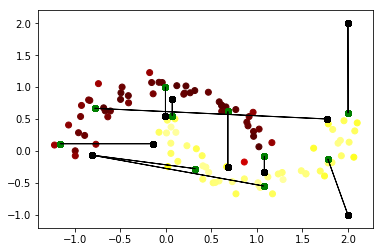

In [3]:
# get attack
attack = HighConfidenceLowUncertainty(m_art,conf=0.75,min_val=-1.0,max_val=2.0)
# generate examples and plot them
adv = attack.generate(Xt)
plt.scatter(X[:,0],X[:,1],c=cm.hot(m_art.predict(X)[:,0].reshape(-1)))
for i in range(np.shape(Xt)[0]):
    plt.scatter(Xt[:,0],Xt[:,1],c='green')
    plt.scatter(adv[:,0],adv[:,1],c='k')
    plt.arrow(Xt[i,0], Xt[i,1], adv[i,0]-Xt[i,0], adv[i,1]-Xt[i,1])

### Uncertainty optimized adversarial examples
We can additionally optimize for uncetainty by setting unc_increase to 0.9, thereby forcing the adversarial examples to be closer to the original training data.

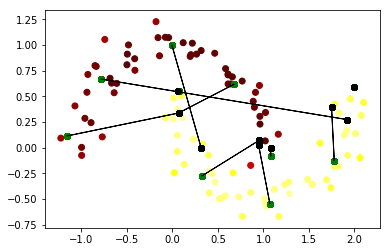

In [4]:
attack = HighConfidenceLowUncertainty(m_art,unc_increase=0.9,min_val=0.0,max_val=2.0)
adv = attack.generate(Xt)
plt.scatter(X[:,0],X[:,1],c=cm.hot(m_art.predict(X)[:,0].reshape(-1)))
for i in range(np.shape(Xt)[0]):
    plt.scatter(Xt[:,0],Xt[:,1],c='green')
    plt.scatter(adv[:,0],adv[:,1],c='k')
    plt.arrow(Xt[i,0], Xt[i,1], adv[i,0]-Xt[i,0], adv[i,1]-Xt[i,1])
plt.show()

### PGD on Guassian process classification
To conclude, we show how to compute PGD adversarial exmples on our model. We observe that as before, many attempts fail, as the model misleads the attack to take a wrong path away from the boundary. In this case, examples are classified as default: either of the two classes.

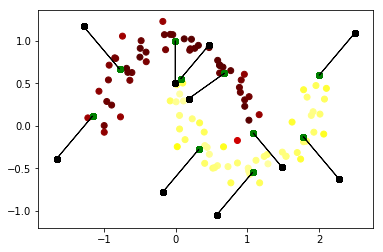

In [5]:
attack = ProjectedGradientDescent(m_art,eps=0.5,eps_step=0.2) #TODO,targeted=True)
adv = attack.generate(Xt)
plt.scatter(X[:,0],X[:,1],c=cm.hot(m_art.predict(X)[:,0].reshape(-1)))
for i in range(np.shape(Xt)[0]):
    plt.scatter(Xt[:,0],Xt[:,1],c='green')
    plt.scatter(adv[:,0],adv[:,1],c='k')
    plt.arrow(Xt[i,0], Xt[i,1], adv[i,0]-Xt[i,0], adv[i,1]-Xt[i,1])
plt.show()